### This notebook plots pseudo-density profiles for Earth

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
from astropy.time import Time
import importlib
sys.path.append('/Users/nathanielruhl/Documents/HorizonCrossings-project-Git/HCNM2')

# Classes for fitting the transmittance data
from Modules import FitAtmosphere as fa
from Modules import LocateR0hcNav as r0hc
importlib.reload(fa)
importlib.reload(r0hc)

# Aditional function to read and do some preliminary processing on RXTE data
from Modules.read_rxte_data import read_rxte_data
from Modules.tools import celestial_to_geocentric
from Modules import constants
from DensityRetrieval.gaussxw import gaussxwab

# import observation dictionary
from ObservationDictionaries.RXTE.all_dicts import all_dicts
a1 = np.arange(6, 28, 3)
a2 = np.arange(9, 31, 3)
e_band_ch_array = np.column_stack((a1, a2))

# With the substitution y=z/(1-z)+r, we can integrate y=[r,oo] via z=[0,1]
def integrand(z, r, fit_obj):
    a = fit_obj.a_fit
    b = fit_obj.b_fit
    c = fit_obj.c_fit
    d = fit_obj.d_fit
    return a*b/(np.pi*(1 - z**2)*np.sqrt(-r**2 + (r + z/(1 - z))**2)*(a*np.sinh(b*(-c + r + z/(1 - z))) + d*np.cosh(b*(-c + r + z/(1 - z)))))

In [2]:
def calcTOD(obs_dict):
    r_sun_obj = ap.coordinates.get_sun(Time(obs_dict["t_mid_datetime"]))
    ra = np.deg2rad(r_sun_obj.ra).radian
    dec = np.deg2rad(r_sun_obj.dec).radian
    r_sun = celestial_to_geocentric(ra, dec)
    r_source = obs_dict["starECI"]
    tod_angle = np.arccos(np.dot(r_sun, r_source))
    return tod_angle

# This function calculates the acute angle between the Earth and the Sun in the SSB frame
def calcTOY(obs_dict):
    r_sun_obj = ap.coordinates.get_body_barycentric("sun", Time(obs_dict["t_mid_datetime"]))
    r_sun = np.array((r_sun_obj/r_sun_obj.norm()).xyz)
    r_earth_obj = ap.coordinates.get_body_barycentric("earth", Time(obs_dict["t_mid_datetime"]))
    r_earth = np.array((r_earth_obj/r_earth_obj.norm()).xyz)
    toy_angle = np.arccos(np.dot(r_sun, r_earth))
    return toy_angle

for obs_dict in all_dicts:
    obs_dict['TOY'] = calcTOY(obs_dict)
    obs_dict['TOD'] = calcTOD(obs_dict)

In [3]:
def calc_gamma_profile(obs_dict, e_band_ch):

    r0_obj=r0hc.LocateR0hcNav(obs_dict, 'rossi', h0_ref=0)

    #2) Read in RXTE data for the specified energy band
    rate_data, time_data, normalized_amplitudes, bin_centers_kev, unattenuated_rate, e_band_kev=read_rxte_data(obs_dict, e_band_ch)
    transmit_data = rate_data/unattenuated_rate

    #3) Fit count rate vs h (geocentric tangent altitudes above y0_ref)
    fit_obj=fa.FitAtmosphere(obs_dict, 'rossi', r0_obj, rate_data, time_data, unattenuated_rate, e_band_kev)

    #4) Determine the pseudo-density profile
    N=50
    z, w = gaussxwab(N,0.0,1.0) # Calculate sample points and weights
    gamma_measured = np.zeros_like(fit_obj.y_measured)   # pseudo-density
    for indx, r in enumerate(fit_obj.y_measured):
        s=0.0
        for k in range(N):
            s+=w[k]*integrand(z[k], r, fit_obj)
        gamma_measured[indx] = s
    return fit_obj, gamma_measured

obsID=91802


Text(0.5, 0, 'Tangent Altitude (km)')

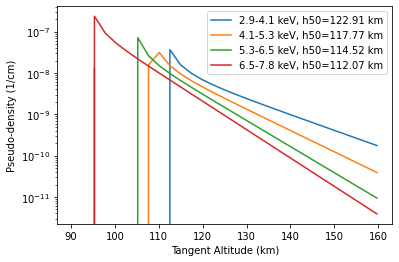

In [31]:
obs_dict = all_dicts[0]
print(f'obsID={obs_dict["obsID"]}')
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
plt.figure()
i=0
for e_band_ch in e_band_ch_array[0:4]:
    fit_obj, gamma_measured = calc_gamma_profile(obs_dict, e_band_ch)
    range_i = np.where((fit_obj.h_measured>90) & (fit_obj.h_measured<160))[0]
    plt.plot(fit_obj.h_measured[range_i], gamma_measured[range_i]*10**(-5.), color=colors[i], label = f"{fit_obj.e_band_kev[0]:.1f}-{fit_obj.e_band_kev[1]:.1f} keV, h50={fit_obj.h50_fit:.2f} km")
    i+=1
plt.yscale('log')
plt.legend()
plt.ylabel("Pseudo-density (1/cm)")
plt.xlabel("Tangent Altitude (km)")

The plot above shows how the pseudo-censity profile is different for different energy bands, in a given observation.
The plot below shows the pseudo-density profiles of a given energy range for different observations

6.5-7.8 keV


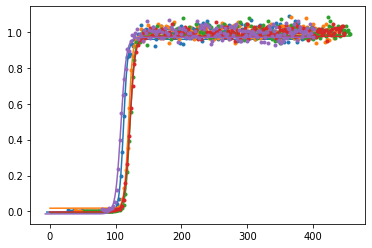

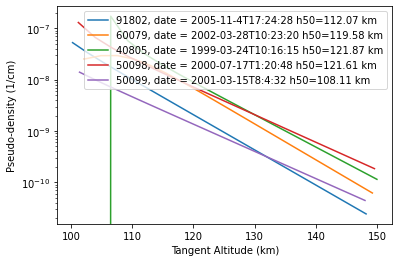

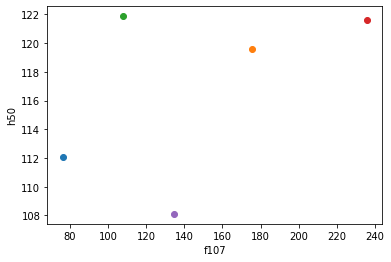

In [64]:
e_band_ch = e_band_ch_array[3]
i=0
for obs_dict in all_dicts:
    fit_obj, gamma_measured = calc_gamma_profile(obs_dict, e_band_ch)
    range_i = np.where((fit_obj.h_measured>100) & (fit_obj.h_measured<150))[0]
    plt.figure(1)
    plt.plot(fit_obj.h_measured[range_i], gamma_measured[range_i]*10**(-5.), 
             color=colors[i], label = f"{obs_dict['obsID']}, date = {obs_dict['t_mid_datetime']} h50={fit_obj.h50_fit:.2f} km")
    
    plt.figure(2)
    plt.scatter(obs_dict["f107"], fit_obj.h50_fit, color=colors[i])
    
    plt.figure(3)
    # make sure the fit looks good
    h_fit = np.linspace(min(fit_obj.h_measured), max(fit_obj.h_measured), 1000)
    plt.plot(fit_obj.h_measured, fit_obj.transmit_measured, '.', color=colors[i])
    plt.plot(h_fit, fit_obj.transmit_vs_y(h_fit+fit_obj.y0_ref, *fit_obj.popt))
    
    i+=1

plt.figure(1)
plt.yscale('log')
plt.legend()
plt.ylabel("Pseudo-density (1/cm)")
plt.xlabel("Tangent Altitude (km)")

plt.figure(2)
plt.ylabel("h50")
plt.xlabel("f107")
print(f"{fit_obj.e_band_kev[0]:.1f}-{fit_obj.e_band_kev[1]:.1f} keV")

purple has a very small Ap index